In [1]:
import numpy as np
#import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
import matplotlib.pyplot as plt

# ガウシアン独立モデルを利用したVaR推定
ここでは、以下のパラメータで計算を行っている。

- 資産の数：２個
- 各資産の最大損失額：(100, 100)
- ガウシアン独立モデル（GCI）のパラメータ
    - デフォルトの確率（p0）：(0.01, 0.01)
    - GCIを調整するパラメータ：(0.1, 0.1)
- VaR推定のパーセンタイル点：99%

In [2]:
# set problem parameters
n_z = 2 #資産の数
z_max = 2 #生成する乱数zの数

p_zeros = [0.01, 0.01] #デフォルトの確率
rhos = [0.1, 0.1] #GCIを調整するパラメータ
lgd = [100, 100] #各資産の最大損失額

K = len(p_zeros) #描画用のパラメータ
z_values = np.linspace(-z_max, z_max, 2**n_z) #zをプロットするための横軸

alpha = 0.01 #VaR推定のパーセンタイル点（0~1で設定可能、）
epsilon = 0.01 #量子振幅推定における誤差の許容範囲（0〜0.5で設定可能）

In [3]:
u = GCI(n_z, z_max, p_zeros, rhos)
u.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘

In [4]:
u_measure = u.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(u_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [5]:
# analyze uncertainty circuit and determine exact solutions

p_z = np.zeros(2**n_z) #zが生成される確率を格納するリスト
p_default = np.zeros(K) #zにより計算されるpiを格納するリスト


values = [] 
probabilities = []
num_qubits = u.num_qubits
qubit_state = []
qubit_probabilities = []

for i, prob in binary_probabilities.items():
    #print(i,prob)
    qubit_state.append([i,prob])
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]

qubit_state.sort()
#print(qubit_state)

values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

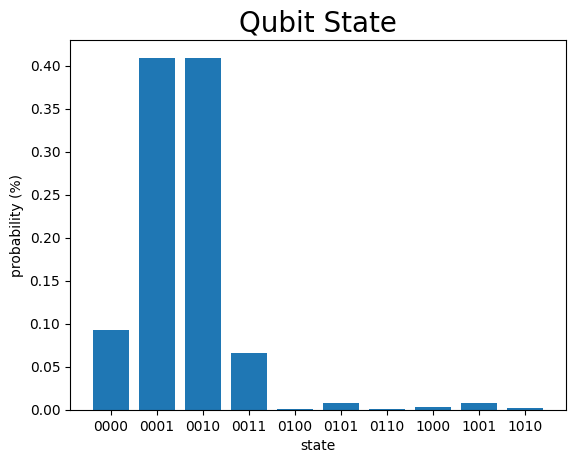

In [6]:
# plot probabilities of each states
q_state = []
q_prob = []
for state in qubit_state:
    q_state.append(state[0])
    q_prob.append(state[1])

plt.bar(q_state,q_prob)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

【図の見方】  
横軸は量子ビットの状態で、うち前半の２量子ビットがpiに相当。  
縦軸は各量子ビットの状態が得られる確率。  
なので、ここで前半２量子ビットが同じ状態になっているものを足し合わせれば、資産の損失が生じる確率となる。

In [7]:
#analyze Expetcedd Loss and Value at Risk in calssical computing method

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
#exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
#print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
#print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                2.2461
Value at Risk VaR[L]:              100.0000


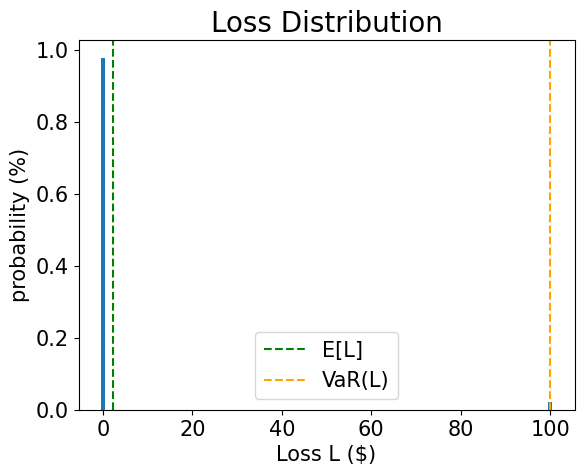

In [8]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
#plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

【図の見方】  
横軸は損失額。縦軸は損失が得られる確率。  
今回の計算の場合、デフォルトの確率が0.01前後と非常に低いので、損失の期待値は0に近くなる。

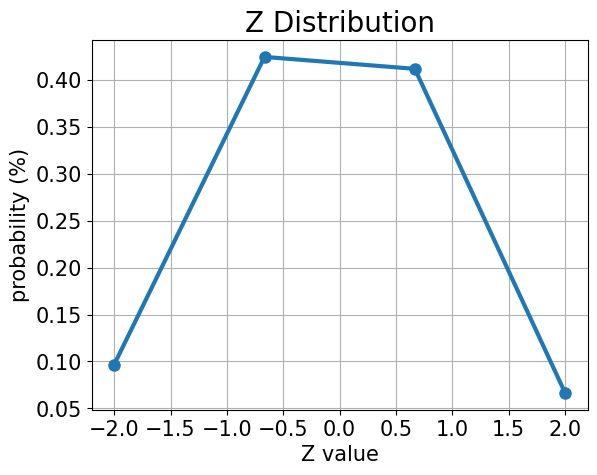

In [9]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

【図の見方】  
横軸はガウシアン独立モデルを生成するZの定義域で、縦軸はzが得られる確率。

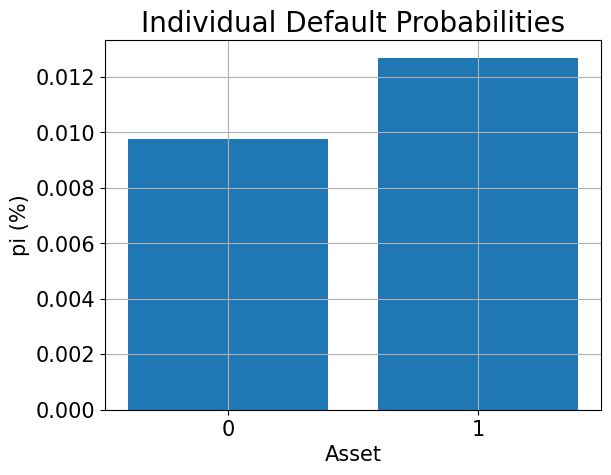

In [10]:
# plot results for default probabilities pi
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("pi (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

【図の見方】  
生成したzから計算されたガウシアン独立モデルの確率pi。  
横軸がそれぞれの資産で、縦軸が資産ごとのpi。

# 損失の期待値Lを量子コンピュータで計算する方法
上では、ガウシアン独立モデルの確率piは量子コンピュータで生成するものの、そこから先は古典コンピュータで計算を行っていた。
以下では、損失の期待値E(L)までを量子コンピュータ上で計算するコードになる。

In [11]:
# add Z qubits with weight/loss 0
from qiskit.circuit.library import WeightedAdder

agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

In [12]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [13]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
  state_0: ┤0      ├┤0        ├──────┤0           ├
           │       ││         │      │            │
  state_1: ┤1      ├┤1        ├──────┤1           ├
           │  P(X) ││         │      │            │
  state_2: ┤2      ├┤2        ├──────┤2           ├
           │       ││         │      │            │
  state_3: ┤3      ├┤3        ├──────┤3           ├
           └───────┘│         │┌────┐│            │
objective: ─────────┤         ├┤8   ├┤            ├
                    │         ││    ││            │
    sum_0: ─────────┤4        ├┤0   ├┤4           ├
                    │         ││    ││            │
    sum_1: ─────────┤5        ├┤1   ├┤5           ├
                    │         ││    ││            │
    sum_2: ─────────┤6        ├┤2   ├┤6           ├
                    │         ││    ││            │
    sum_3: ─────────┤7        ├┤3 F ├┤7           ├
                    │         ││    ││            │
    sum_4: ─────────┤8        ├┤4   ├┤8           ├
                    │         ││    ││            │
    sum_5: ─────────┤9  adder ├┤5   ├┤9  adder_dg ├
                    │         ││    ││            │
    sum_6: ─────────┤10       ├┤6   ├┤10          ├
                    │         ││    ││            │
    sum_7: ─────────┤11       ├┤7   ├┤11          ├
                    │         │└────┘│            │
  carry_0: ─────────┤12       ├──────┤12          ├
                    │         │      │            │
  carry_1: ─────────┤13       ├──────┤13          ├
                    │         │      │            │
  carry_2: ─────────┤14       ├──────┤14          ├
                    │         │      │            │
  carry_3: ─────────┤15       ├──────┤15          ├
                    │         │      │            │
  carry_4: ─────────┤16       ├──────┤16          ├
                    │         │      │            │
  carry_5: ─────────┤17       ├──────┤17          ├
                    │         │      │            │
  carry_6: ─────────┤18       ├──────┤18          ├
                    │         │      │            │
  carry_7: ─────────┤19       ├──────┤19          ├
                    └─────────┘      └────────────┘

In [14]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [15]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   2.2461
Exact Operator Value:  0.3105
Mapped Operator value: 3.5123


In [ ]:
# set target precision and confidence level



problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

# VaR推定を量子コンピュータで計算する方法
ここまでで、損失の期待値を量子コンピュータ上で計算することが出来た。
最後に、VaR推定を量子コンピュータ上で実行するコードを以下に示す。

In [ ]:
# set x value to estimate the CDF
x_eval = 10

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

In [ ]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:-1])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

    return state_preparation


state_preparation = get_cdf_circuit(x_eval)

In [ ]:
state_preparation.draw()

In [ ]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [ ]:
# evaluate the result
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[1])

In [ ]:
# set target precision and confidence level
epsilon = 0.01

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[1])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))


In [ ]:
def run_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
    )
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [ ]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [ ]:
# run bisection search to determine VaR
objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

In [ ]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[1])